<a href="https://colab.research.google.com/github/annchirackal/Tensorflow-Developer-Certification/blob/TF_Transfer_Learning/12_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#####What is transfer learning?<br>

we can leverage an existing nueral network architecture proven to work on similar problems which is already learned patterns from dataset  similar  to our own.



Download the data:
we are going to use only 10 percent data, this would help us to understand the powe of transfer learning.

In [1]:
import tensorflow as tf
import zipfile
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
import datetime

import tensorflow_hub as hub
from tensorflow.keras import layers

In [2]:
## Global variables
IMAGE_SHAPE=(224,224)
BATCH_SIZE=32
EPOCHS=5

In [3]:
 !wget -q https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

In [4]:
# unzip the loaded file
zip_ref=zipfile.ZipFile("/content/10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

In [5]:
  #lets inspect the directory
for dirpath,dirnames,filenames in os.walk("10_food_classes_10_percent"):

    print(f"{len(filenames)} files and  {len(dirnames)} in directory {dirpath}")


0 files and  2 in directory 10_food_classes_10_percent
0 files and  10 in directory 10_food_classes_10_percent/test
250 files and  0 in directory 10_food_classes_10_percent/test/hamburger
250 files and  0 in directory 10_food_classes_10_percent/test/pizza
250 files and  0 in directory 10_food_classes_10_percent/test/sushi
250 files and  0 in directory 10_food_classes_10_percent/test/chicken_wings
250 files and  0 in directory 10_food_classes_10_percent/test/fried_rice
250 files and  0 in directory 10_food_classes_10_percent/test/ramen
250 files and  0 in directory 10_food_classes_10_percent/test/chicken_curry
250 files and  0 in directory 10_food_classes_10_percent/test/grilled_salmon
250 files and  0 in directory 10_food_classes_10_percent/test/ice_cream
250 files and  0 in directory 10_food_classes_10_percent/test/steak
0 files and  10 in directory 10_food_classes_10_percent/train
75 files and  0 in directory 10_food_classes_10_percent/train/hamburger
75 files and  0 in directory 10_

We have 75 images of each class for traning and 250 from each class for validation

In [6]:
 #### set the path variables

train_dir="/content/10_food_classes_10_percent/train"
test_dir="/content/10_food_classes_10_percent/test"

train_data_gen=ImageDataGenerator(rescale=1./255,)
test_data_gen=ImageDataGenerator(rescale=1./255,)
print("Traning Images:")
train_data=train_data_gen.flow_from_directory(train_dir,
                                              target_size=IMAGE_SHAPE,
                                              batch_size=BATCH_SIZE,
                                              class_mode="categorical")
print("Testing Images:")
test_data=train_data_gen.flow_from_directory(test_dir,
                                              target_size=IMAGE_SHAPE,
                                              batch_size=BATCH_SIZE,
                                              class_mode="categorical")


Traning Images:
Found 750 images belonging to 10 classes.
Testing Images:
Found 2500 images belonging to 10 classes.


Callbacks are extra functionality you can add to your model to be performed during or after training.Some of the most popular call backs are
- Model check point with the ModelCheckpoint callbacks.
- Tracking experiment with tensor board callbacks.
- Stopping a model from traning with EarlyStopping callbacks.

In [7]:
#create a tensorboard callbacks

def create_tensorboard_callback(dirname,experiment_name):
  log_dir=dirname+"/"+experiment_name+datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback=tf.keras.callbacks.TensorBoard(log_dir=log_dir,)
  print(f"Saving TensorBorad log files to {log_dir} ")
  return tensorboard_callback


Creating Models using Tensorflow hub<br>

In previous notebooks we have created custom models from scratch. Here we are creating a model by using layers from pretrained models availble in tensor hub.


In [8]:
# Resnet 50 V2 feature vector
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

# Original: EfficientNetB0 feature vector (version 1)
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

# # New: EfficientNetB0 feature vector (version 2)
# efficientnet_url = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2"

In [9]:
def create_model(model_url, num_classes=10):
  """Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.

  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in output layer,
      should be equal to number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature
    extractor layer and Dense output layer with num_classes outputs.
  """
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze the underlying patterns
                                           name='feature_extraction_layer',
                                           input_shape=IMAGE_SHAPE+(3,)) # define the input image shape

  # Create our own model
  model = tf.keras.Sequential([
    feature_extractor_layer, # use the feature extraction layer as the base
    layers.Dense(num_classes, activation='softmax', name='output_layer') # create our own output layer
  ])

  return model


In [10]:
# Create model
resnet_model = create_model(resnet_url, num_classes=train_data.num_classes)

# Compile
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])


In [11]:
# Fit the model
resnet_history = resnet_model.fit(train_data,
                                  epochs=5,
                                  steps_per_epoch=len(train_data),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  # Add TensorBoard callback to model (callbacks parameter takes a list)
                                  callbacks=[create_tensorboard_callback(dirname="tensorflow_hub", # save experiment logs here
                                                                         experiment_name="resnet50V2")]) # name of log

Saving TensorBorad log files to tensorflow_hub/resnet50V220240220-190626 
Epoch 1/5
24/24 [==============================] - 21s 564ms/step - loss: 2.0154 - accuracy: 0.3067 - val_loss: 1.3272 - val_accuracy: 0.5820
Epoch 2/5
24/24 [==============================] - 10s 443ms/step - loss: 0.9480 - accuracy: 0.7147 - val_loss: 0.9131 - val_accuracy: 0.7052
Epoch 3/5
24/24 [==============================] - 11s 460ms/step - loss: 0.6342 - accuracy: 0.8147 - val_loss: 0.7728 - val_accuracy: 0.7536
Epoch 4/5
24/24 [==============================] - 10s 442ms/step - loss: 0.4806 - accuracy: 0.8760 - val_loss: 0.7282 - val_accuracy: 0.7724
Epoch 5/5
24/24 [==============================] - 10s 447ms/step - loss: 0.3834 - accuracy: 0.9080 - val_loss: 0.6999 - val_accuracy: 0.7740


Eventhouogh we used olnly 10% of the training data, we can see that the model performence increased compared to last one.

In [12]:
# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

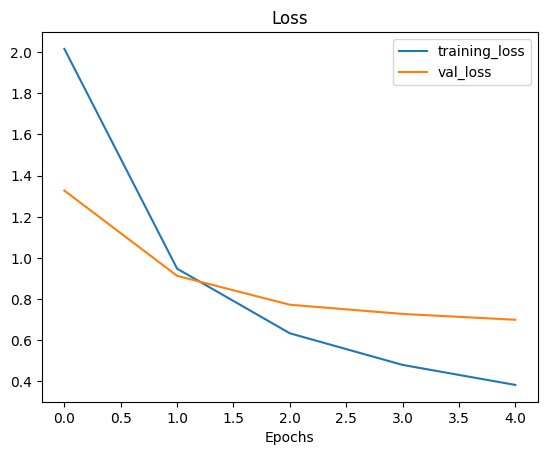

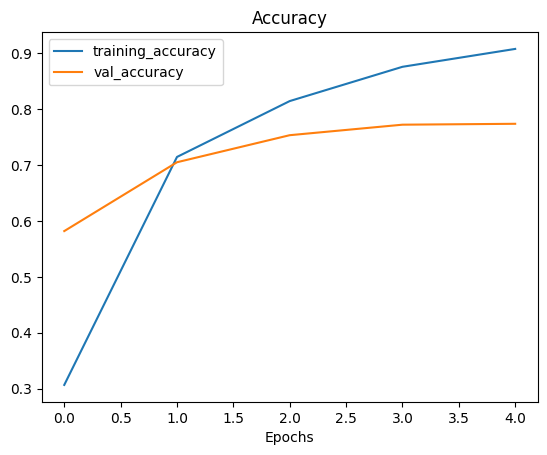

In [13]:
plot_loss_curves(resnet_history)

In [14]:
# Create model
efficientnet_model = create_model(model_url=efficientnet_url, # use EfficientNetB0 TensorFlow Hub URL
                                  num_classes=train_data.num_classes)

# Compile EfficientNet model
efficientnet_model.compile(loss='categorical_crossentropy',
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=['accuracy'])

# Fit EfficientNet model
efficientnet_history = efficientnet_model.fit(train_data, # only use 10% of training data
                                              epochs=5, # train for 5 epochs
                                              steps_per_epoch=len(train_data),
                                              validation_data=test_data,
                                              validation_steps=len(test_data),
                                              callbacks=create_tensorboard_callback(dirname="tensorflow_hub",
                                                                                     # Track logs under different experiment name
                                                                                     experiment_name="efficientnetB0"))

Saving TensorBorad log files to tensorflow_hub/efficientnetB020240220-190752 
Epoch 1/5
24/24 [==============================] - 23s 544ms/step - loss: 1.8836 - accuracy: 0.4107 - val_loss: 1.3166 - val_accuracy: 0.7184
Epoch 2/5
24/24 [==============================] - 13s 539ms/step - loss: 1.0695 - accuracy: 0.7760 - val_loss: 0.8719 - val_accuracy: 0.8112
Epoch 3/5
24/24 [==============================] - 13s 541ms/step - loss: 0.7545 - accuracy: 0.8373 - val_loss: 0.7011 - val_accuracy: 0.8388
Epoch 4/5
24/24 [==============================] - 10s 412ms/step - loss: 0.6046 - accuracy: 0.8760 - val_loss: 0.6118 - val_accuracy: 0.8532
Epoch 5/5
24/24 [==============================] - 11s 471ms/step - loss: 0.5116 - accuracy: 0.8987 - val_loss: 0.5574 - val_accuracy: 0.8612


# Transfer Learning with Tensorflow - Fine Tuning

In [15]:
# Get helper_functions.py script from course GitHub
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import helper functions we're going to use
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

--2024-02-20 19:09:19--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-02-20 19:09:19 (94.3 MB/s) - ‘helper_functions.py’ saved [10246/10246]



###Let's get some data
Now we are going to use inbuild models in tf.keras.applications

In [16]:
# Get 10% of the data of the 10 classes
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("10_food_classes_10_percent.zip")

--2024-02-20 19:09:20--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.200.207, 74.125.130.207, 64.233.170.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.200.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.1’

10_food_classes_10_ 100%[===================>] 160.74M  21.2MB/s    in 8.6s    

2024-02-20 19:09:29 (18.8 MB/s) - ‘10_food_classes_10_percent.zip.1’ saved [168546183/168546183]



In [17]:

# Walk through 10 percent data directory and list number of files
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent

In [18]:

# Create training and test directories
train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

In [19]:
 #Create data inputs
import tensorflow as tf
IMG_SIZE = (224, 224) # define image size
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical", # what type are the labels?
                                                                            batch_size=32) # batch_size is 32 by default, this is generally a good number
test_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                           image_size=IMG_SIZE,
                                                                           label_mode="categorical")


Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [20]:

# Check the training data datatype
train_data_10_percent

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

### Model 0 : Tranfer learnig feature extraction using keras functional API
sequtional API's are straight forward , it passes the data through layers in sequential manner . But functional API gives us more flexibility


In [24]:
# 1. Create base model with tf.keras.applications
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)

# OLD
# base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the base model (so the pre-learned patterns remain)
base_model.trainable = False

# 3. Create inputs into the base model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

# 4. If using ResNet50V2, add this to speed up convergence, remove for EfficientNetV2
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base_model (note: using tf.keras.applications, EfficientNetV2 inputs don't have to be normalized)
x = base_model(inputs)
# Check data shape after passing it to base_model
print(f"Shape after base_model: {x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"After GlobalAveragePooling2D(): {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8. Combine the inputs with the outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# 10. Fit the model (we use less steps for validation so it's faster)
history_10_percent = model_0.fit(train_data_10_percent,
                                 epochs=5,
                                 steps_per_epoch=len(train_data_10_percent),
                                 validation_data=test_data_10_percent,
                                 # Go through less of the validation data so epochs are faster (we want faster experiments!)
                                 validation_steps=int(0.25 * len(test_data_10_percent)),
                                 # Track our model's training logs for visualization later
                                 callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_feature_extract")])


24274472/24274472 [==============================] - 2s 0us/step
Shape after base_model: (None, 7, 7, 1280)
After GlobalAveragePooling2D(): (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extract/20240220-191112
Epoch 1/5
24/24 [==============================] - 16s 252ms/step - loss: 1.8552 - accuracy: 0.4387 - val_loss: 1.2901 - val_accuracy: 0.7303
Epoch 2/5
24/24 [==============================] - 4s 158ms/step - loss: 1.1467 - accuracy: 0.7347 - val_loss: 0.8644 - val_accuracy: 0.8322
Epoch 3/5
24/24 [==============================] - 4s 137ms/step - loss: 0.8429 - accuracy: 0.8160 - val_loss: 0.6896 - val_accuracy: 0.8470
Epoch 4/5
24/24 [==============================] - 4s 150ms/step - loss: 0.6919 - accuracy: 0.8520 - val_loss: 0.5832 - val_accuracy: 0.8668
Epoch 5/5
24/24 [==============================] - 5s 190ms/step - loss: 0.6089 - accuracy: 0.8507 - val_loss: 0.5302 - val_accuracy: 0.8635


In [25]:

base_model.summary()

Model: "efficientnetv2-b0"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 rescaling_2 (Rescaling)     (None, None, None, 3)        0         ['input_2[0][0]']             
                                                                                                  
 normalization_1 (Normaliza  (None, None, None, 3)        0         ['rescaling_2[0][0]']         
 tion)                                                                                            
                                                                                                  
 stem_conv (Conv2D)          (None, None, None, 32)       864       ['normalizatio

In [22]:

# Check layers in our base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_1
1 rescaling
2 normalization
3 rescaling_1
4 stem_conv_pad
5 stem_conv
6 stem_bn
7 stem_activation
8 block1a_dwconv
9 block1a_bn
10 block1a_activation
11 block1a_se_squeeze
12 block1a_se_reshape
13 block1a_se_reduce
14 block1a_se_expand
15 block1a_se_excite
16 block1a_project_conv
17 block1a_project_bn
18 block2a_expand_conv
19 block2a_expand_bn
20 block2a_expand_activation
21 block2a_dwconv_pad
22 block2a_dwconv
23 block2a_bn
24 block2a_activation
25 block2a_se_squeeze
26 block2a_se_reshape
27 block2a_se_reduce
28 block2a_se_expand
29 block2a_se_excite
30 block2a_project_conv
31 block2a_project_bn
32 block2b_expand_conv
33 block2b_expand_bn
34 block2b_expand_activation
35 block2b_dwconv
36 block2b_bn
37 block2b_activation
38 block2b_se_squeeze
39 block2b_se_reshape
40 block2b_se_reduce
41 block2b_se_expand
42 block2b_se_excite
43 block2b_project_conv
44 block2b_project_bn
45 block2b_drop
46 block2b_add
47 block3a_expand_conv
48 block3a_expand_bn
49 block3a_expand_activation
5

In [26]:

# Check summary of model constructed with Functional API
model_0.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Functio  (None, None, None, 1280   5919312   
 nal)                        )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 5932122 (22.63 MB)
Trainable params: 12810 (50.04 KB)
Non-trainable params: 5919312 (22.58 MB)
________________

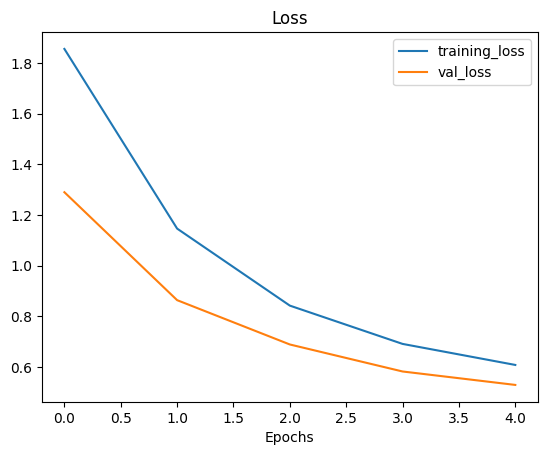

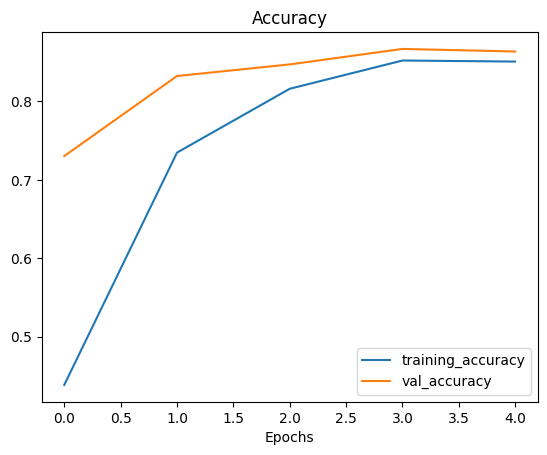

In [27]:

# Check out our model's training curves
plot_loss_curves(history_10_percent)

In [28]:
# Define input tensor shape (same number of dimensions as the output of efficientnetv2-b0)
input_shape = (1, 4, 4, 3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor:\n {input_tensor}\n")

# Pass the random tensor through a global average pooling 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor:\n {global_average_pooled_tensor}\n")

# Check the shapes of the different tensors
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of 2D global averaged pooled input tensor: {global_average_pooled_tensor.shape}")

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338894  0.97772694]
   [ 0.24694404  0.20573746 -0.52562326]
   [ 0.32410017  0.02545409 -0.10638496]
   [-0.63694745  1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815628  0.23479679 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

2D global average pooled random tensor:
 [[-0.09368646 -0.45840448 -0.2885598 ]]

Shape of input tensor: (1, 4, 4, 3)
Shape of 2D global averaged pooled input tensor: (1, 3)
